In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange 

In [2]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [3]:
from torch_utility import *

## import dataset

In [4]:
Xtrain, Xtest, ytrain, ytest = load_monk("3")

In [5]:
ytrain = ytrain.reshape(ytrain.shape[0], 1)
ytest = ytest.reshape(ytest.shape[0], 1)

In [6]:
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(122, 17)
(432, 17)
(122, 1)
(432, 1)


In [7]:
train_dataset = TensorDataset(torch.Tensor(Xtrain), torch.Tensor(ytrain))
# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
train_loader = DataLoader(train_dataset)

In [8]:
# test_dataset = TensorDataset(torch.Tensor(Xtest), torch.Tensor(ytest))
# test_loader = DataLoader(test_dataset)

In [9]:
# Xtest, ytest = torch.Tensor(Xtest), torch.Tensor(ytest)

## Define Models

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(17,4)
        self.hidden1 = nn.Linear(4,1)

    def forward(self, x):
        x = torch.tanh(self.input_layer(x))
        x = torch.tanh(self.hidden1(x))
        return x

In [11]:
def train(net, optimizer, criterion, epochs=100, val_split=None):
    loss_list = []
    acc_list = []
    val_loss_list = []
    val_acc_list = []
    history = {"loss" : loss_list, "acc" : acc_list,
               "val_loss": val_loss_list, "val_acc" : val_acc_list}
    
#     optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.)
#     criterion = nn.MSELoss()
    
    if (len(val_split) == 2):
        test_dataset = TensorDataset(torch.Tensor(val_split[0]), torch.Tensor(val_split[1]))
        test_loader = DataLoader(test_dataset)
    
    for epoch in (t := trange(epochs)):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            out = net(inputs)
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()
            
        acc,_ = evaluate(net, train_loader, verbose=False)
        val_acc, val_loss = evaluate(net, test_loader, verbose=False, criterion=criterion)
        val_loss_list.append(val_loss)
        loss_list.append(loss)
        acc_list.append(acc)
        val_acc_list.append(val_acc)
        t.set_description('epoch %d/%d loss=%.5f acc=%.2f val_loss=%.5f val_acc=%.2f'
                          %(epoch+1, epochs, loss.item(), acc, val_loss, val_acc))    
            
    return history

In [12]:
def evaluate(net, test_loader, verbose=True, criterion=None):
    correct = 0
    total = 0
    loss = 0

    with torch.no_grad():
        for data in test_loader:
            X,y = data
            output = net(X)
            if (criterion != None):
                    loss = criterion(output, y)
            for idx, i in enumerate(output):
                pred = torch.round(torch.max(i))
                if pred == y[idx]:
                    correct+=1
                total+=1
    if verbose:
        print("Accuracy: ", round(correct/total, 2))
    return round(correct/total, 2), loss

In [234]:
net = Net()
print(net)

Net(
  (input_layer): Linear(in_features=17, out_features=4, bias=True)
  (hidden1): Linear(in_features=4, out_features=1, bias=True)
)


### Initialize the weights

In [235]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
        
net.apply(init_weights)

Net(
  (input_layer): Linear(in_features=17, out_features=4, bias=True)
  (hidden1): Linear(in_features=4, out_features=1, bias=True)
)

In [236]:
optimizer = optim.SGD(net.parameters(),lr = 0.01,momentum = 0.3, weight_decay=0.001)
criterion = nn.MSELoss()

In [237]:
history = train(net, epochs=100, optimizer=optimizer, criterion=criterion, val_split=(Xtest, ytest))

epoch 100/100 loss=0.02808 acc=0.98 val_loss=0.02427 val_acc=0.96: 100%|██████████| 100/100 [00:17<00:00,  5.62it/s]


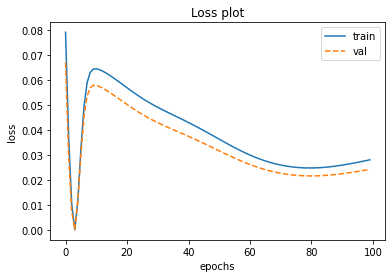

In [238]:
plot_loss(history)

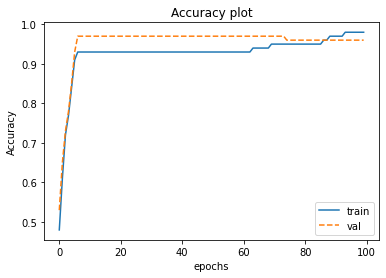

In [239]:
plot_accuracy(history)

In [240]:
data = [
    history['loss'][-1],
    history['acc'][-1],
    history['val_loss'][-1],
    history['val_acc'][-1],
]
table_info(data)

	    MSE     Accuracy
-----------------------------
Train	|0.0280803|	0.98|
Test	|0.0242739|	0.96|
